<a href="https://colab.research.google.com/github/Utkarsh038/INFOSYS-_INTERNSHIP-OIL_SPILL_DETECTION-/blob/main/Oill_split.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:


TRAIN_IMG_DIR = 'drive/MyDrive/Oil_Spill_Dataset/dataset/train/images/'
TRAIN_MASK_DIR = 'drive/MyDrive/Oil_Spill_Dataset/dataset/train/masks/'

print(f"Path to training images: {TRAIN_IMG_DIR}")
print(f"Path to training masks: {TRAIN_MASK_DIR}")

IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16


Path to training images: drive/MyDrive/Oil_Spill_Dataset/dataset/train/images/
Path to training masks: drive/MyDrive/Oil_Spill_Dataset/dataset/train/masks/


Displaying sample images and their corresponding masks...


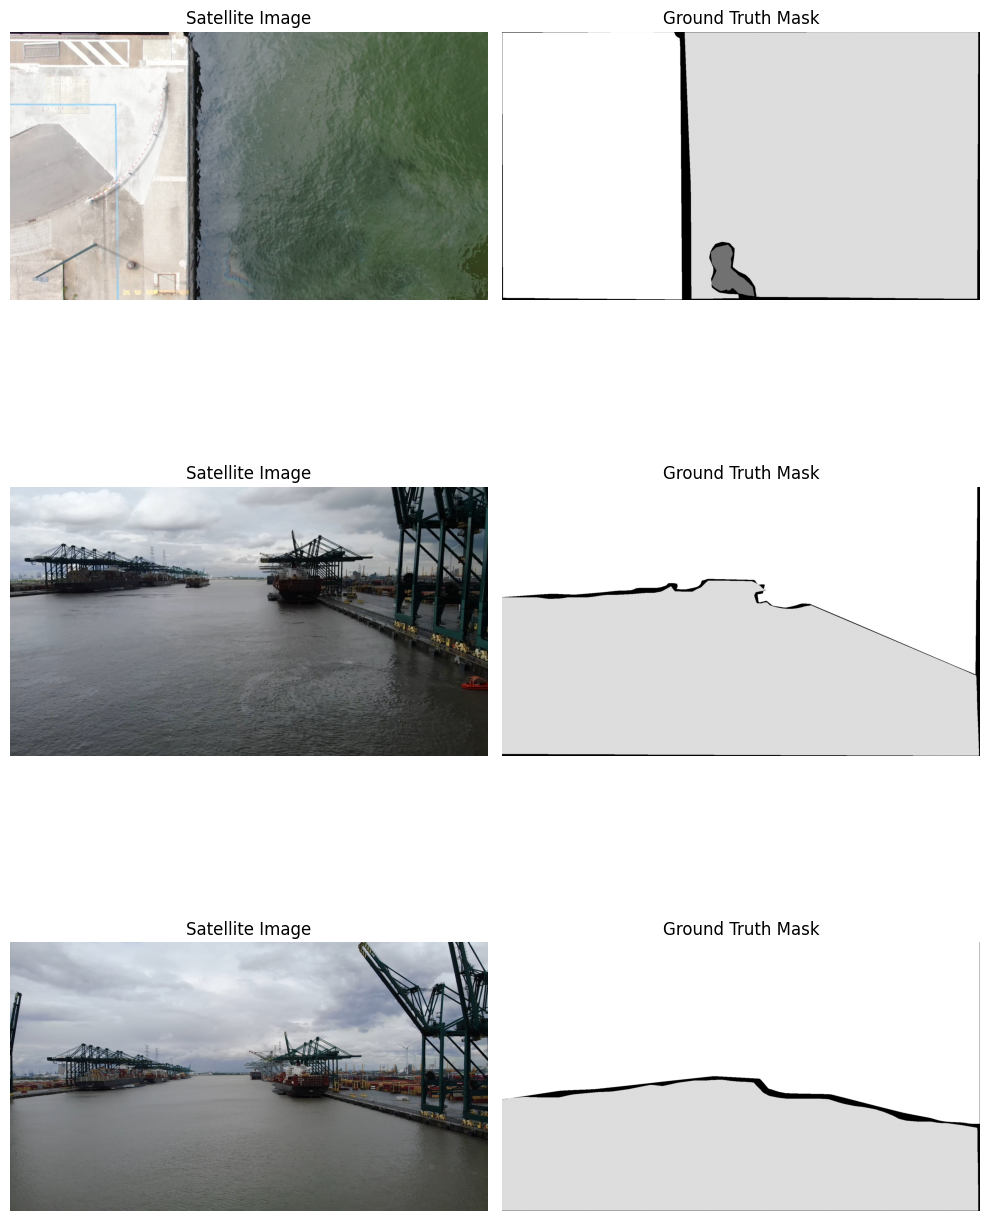

In [4]:
# ==============================================================================
# Step 3: Data Exploration - Visualize Sample Images and Masks
# ==============================================================================

# Get a list of all image and mask files
# Update paths to reflect the cloned repository location
TRAIN_IMG_DIR = '/content/drive/MyDrive/Oil_Spill_Dataset/dataset/train/images/'
TRAIN_MASK_DIR = '/content/drive/MyDrive/Oil_Spill_Dataset/dataset/train/masks/'

train_image_files = sorted([os.path.join(TRAIN_IMG_DIR, f) for f in os.listdir(TRAIN_IMG_DIR)])
train_mask_files = sorted([os.path.join(TRAIN_MASK_DIR, f) for f in os.listdir(TRAIN_MASK_DIR)])

# Function to display images and masks
def display_samples(images, masks, count=3):
    plt.figure(figsize=(10, 5 * count))
    for i in range(count):
        # Load original image
        img = cv2.imread(images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB for plotting

        # Load mask image
        mask = cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE)

        plt.subplot(count, 2, 2 * i + 1)
        plt.title("Satellite Image")
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(count, 2, 2 * i + 2)
        plt.title("Ground Truth Mask")
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display the first 3 samples
print("Displaying sample images and their corresponding masks...")
display_samples(train_image_files, train_mask_files, count=3)


Displaying a sample after preprocessing (resizing, noise reduction, and normalization)...


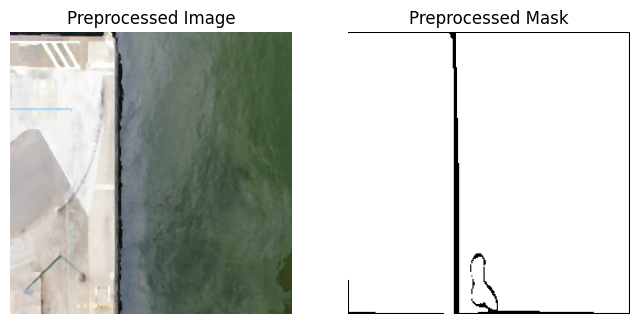

In [5]:
# ==============================================================================
# Data Preprocessing
# ==============================================================================

def preprocess_image(image_path, mask_path):


    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

#    For speckle Noise reduction
    def apply_median_filter(image_tensor):
        image_np = image_tensor.numpy().astype(np.uint8)

        filtered_image = cv2.medianBlur(image_np, 3)
        return filtered_image.astype(np.float32)

    img = tf.py_function(func=apply_median_filter, inp=[img], Tout=tf.float32)
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])

    # Normalize the image pixel values to be between 0 and 1
    img = img / 255.0

    # Read and decode the mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest') # Use 'nearest' for masks
    # Normalize mask to be binary (0 or 1)
    mask = tf.cast(mask > 0, dtype=tf.float32)

    return img, mask


dataset = tf.data.Dataset.from_tensor_slices((train_image_files, train_mask_files))


processed_dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)


print("\nDisplaying a sample after preprocessing (resizing, noise reduction, and normalization)...")
for img, mask in processed_dataset.take(1):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Preprocessed Image")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Preprocessed Mask")
    plt.imshow(tf.squeeze(mask), cmap='gray')
    plt.axis('off')
    plt.show()


Displaying a sample after augmentation...


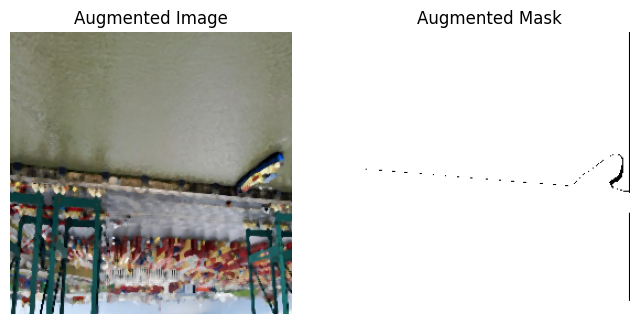


 (Data Exploration, Preprocessing, and Augmentation) is complete.


In [6]:
# ==============================================================================
# Data Augmentation
# ==============================================================================

def augment_data(image, mask):


    combined = tf.concat([image, mask], axis=-1)

    # Random horizontal flip
    combined = tf.image.random_flip_left_right(combined)

    # Random vertical flip
    combined = tf.image.random_flip_up_down(combined)

    # Separate the image and mask again
    image = combined[:, :, :3]
    mask = combined[:, :, 3:]

    # Brightness and contrast adjustments are applied only to the image
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.clip_by_value(image, 0.0, 1.0) # Ensure values remain in [0, 1]

    return image, mask


train_dataset = (
    processed_dataset
    .cache()  # Cache data for performance
    .shuffle(buffer_size=1000)
    .map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Visualize an augmented sample
print("\nDisplaying a sample after augmentation...")
for img, mask in train_dataset.take(1):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Augmented Image")
    plt.imshow(img[0]) # Display the first image in the batch
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Augmented Mask")
    plt.imshow(tf.squeeze(mask[0]), cmap='gray') # Display the first mask in the batch
    plt.axis('off')
    plt.show()

print("\n (Data Exploration, Preprocessing, and Augmentation) is complete.")


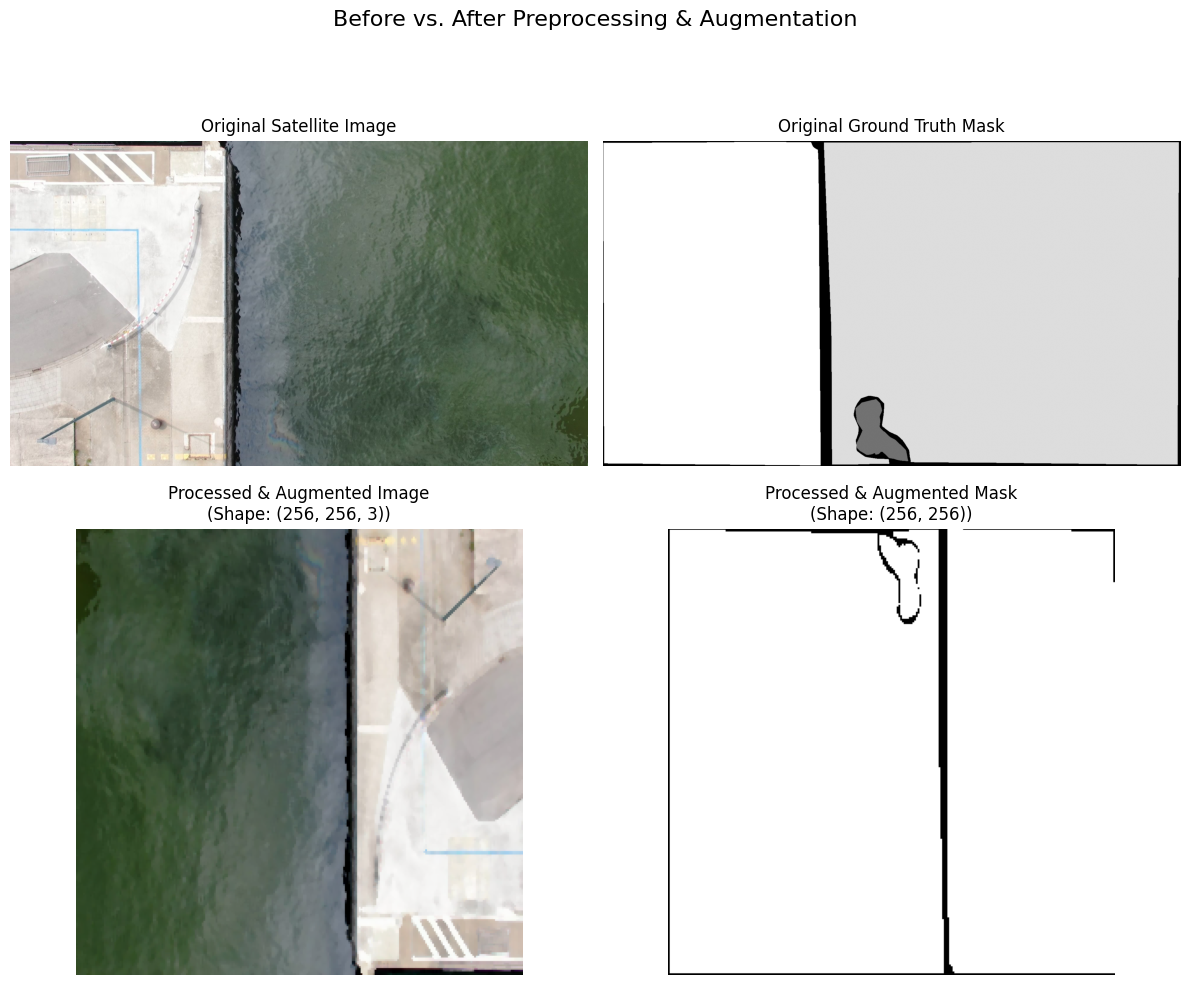

In [7]:
# ==============================================================================
#  Combined Before vs. After Visualization
# ==============================================================================


sample_image_path = train_image_files[0]
sample_mask_path = train_mask_files[0]


original_img = cv2.imread(sample_image_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_mask = cv2.imread(sample_mask_path, cv2.IMREAD_GRAYSCALE)


processed_img, processed_mask = preprocess_image(sample_image_path, sample_mask_path)

augmented_img, augmented_mask = augment_data(processed_img, processed_mask)


plt.figure(figsize=(12, 10))
plt.suptitle("Before vs. After Preprocessing & Augmentation", fontsize=16)

# Top-left: Original Image
plt.subplot(2, 2, 1)
plt.title("Original Satellite Image")
plt.imshow(original_img)
plt.axis('off')

# Top-right: Original Mask
plt.subplot(2, 2, 2)
plt.title("Original Ground Truth Mask")
plt.imshow(original_mask, cmap='gray')
plt.axis('off')

# Bottom-left: Processed & Augmented Image
plt.subplot(2, 2, 3)
plt.title(f"Processed & Augmented Image\n(Shape: {augmented_img.shape})")
plt.imshow(augmented_img)
plt.axis('off')

# Bottom-right: Processed & Augmented Mask
plt.subplot(2, 2, 4)
plt.title(f"Processed & Augmented Mask\n(Shape: {tf.squeeze(augmented_mask).shape})")
plt.imshow(tf.squeeze(augmented_mask), cmap='gray') # Use tf.squeeze to remove the last dimension for plotting
plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()

In [8]:
# ==============================================================================
# Step 6: Build the U-Net Model
# ==============================================================================
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def build_unet_model(input_shape):
    """
    Builds the U-Net architecture.
    """
    inputs = Input(input_shape)

    # --- Contracting Path (Encoder) ---
    # Block 1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Block 2
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # --- Bottleneck ---
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # --- Expanding Path (Decoder) ---
    # Block 6
    u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2]) # Skip connection
    c6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    # Block 7
    u7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1]) # Skip connection
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    # --- Output Layer ---
    # The output is a 1-channel mask. Sigmoid activation gives a probability (0 to 1) for each pixel.
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Define input shape and build the model
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
model = build_unet_model(input_shape)

# Print the model summary to visualize the architecture
print("U-Net Model Architecture:")
model.summary()

U-Net Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 128, 128,  │      8,224 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │     18,464 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_3[0][0] 

 Total params: 117,041 (457.19 KB)

 Trainable params: 117,041 (457.19 KB)

 Non-trainable params: 0 (0.00 B)


Starting model training...
Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 262s 5s/step - accuracy: 0.4664 - dice_coefficient: 0.6694 - iou_metric: 0.5115 - loss: 1.0145 - precision: 0.9524 - recall: 0.4633
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 263s 5s/step - accuracy: 0.9504 - dice_coefficient: 0.9587 - iou_metric: 0.9208 - loss: 0.2662 - precision: 0.9508 - recall: 0.9995
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 267s 5s/step - accuracy: 0.9529 - dice_coefficient: 0.9570 - iou_metric: 0.9177 - loss: 0.2314 - precision: 0.9530 - recall: 0.9999
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 308s 5s/step - accuracy: 0.9533 - dice_coefficient: 0.9569 - iou_metric: 0.9177 - loss: 0.2342 - precision: 0.9534 - recall: 1.0000
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 258s 5s/step - accuracy: 0.9604 - dice_coefficient: 0.9657 - iou_metric: 0.9339 - loss: 0.1867 - precision: 0.9605 - recall: 1.0000
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 244s 5s/step - accuracy: 0.9562 - dice_coefficient: 0.9621 - iou_metric: 0.9271 - lo

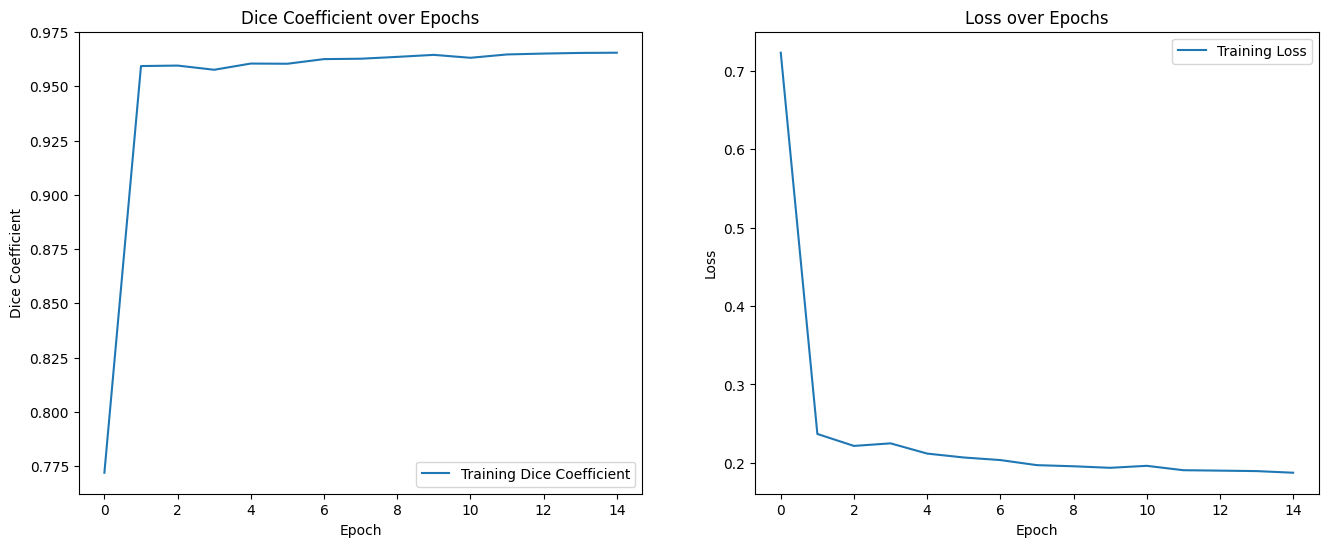

In [9]:
# ==============================================================================
# Step 7: Compile and Train the Model
# ==============================================================================
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow.keras.backend as K

# --- Define Custom Metrics and Loss Functions ---

# Metric: Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Loss Function: A combination of Binary Cross-Entropy and Dice Loss
bce = BinaryCrossentropy()
def combined_loss(y_true, y_pred):
    dice = 1 - dice_coefficient(y_true, y_pred)
    return bce(y_true, y_pred) + dice

# Metric: Intersection over Union (IoU)
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# --- Compile the Model ---
# We compile the model with the Adam optimizer, our combined loss function, and evaluation metrics.
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=combined_loss,
              metrics=[dice_coefficient, iou_metric, 'accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# --- Train the Model ---
# Note: For a real project, you should split your data into training and validation sets.
# Here, we train on the full dataset for demonstration purposes.
EPOCHS = 15   #25
print("\nStarting model training...")

history = model.fit(
    train_dataset,
    epochs=EPOCHS
)

print("Model training complete.")

# ==============================================================================
# Step 8: Visualize Training History
# ==============================================================================

# Plotting the training history helps in evaluating model performance over epochs.
plt.figure(figsize=(16, 6))

# Plot training & validation Dice Coefficient
plt.subplot(1, 2, 1)
plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
plt.title('Dice Coefficient over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Displaying model predictions on sample images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


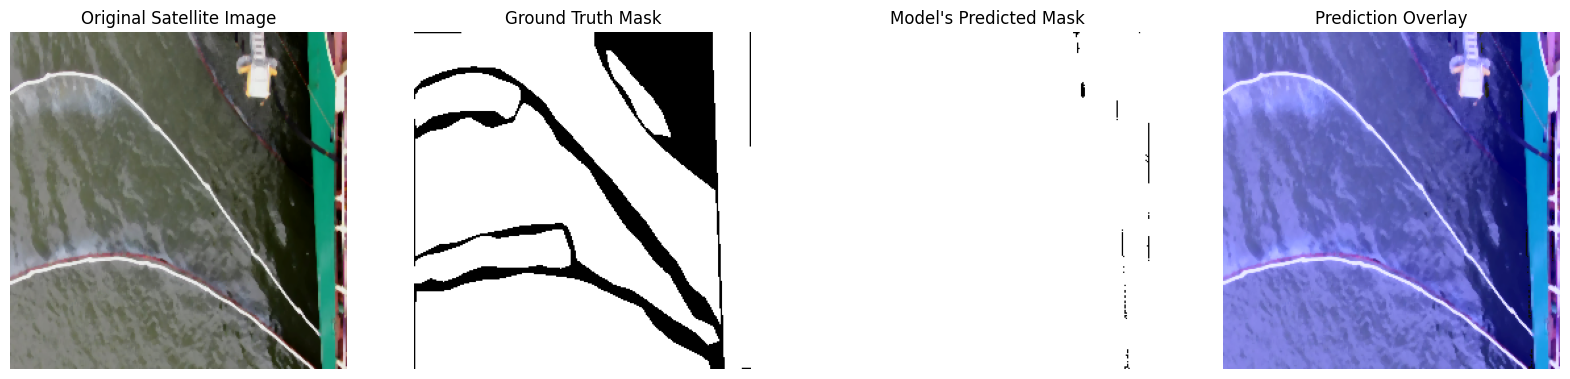

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


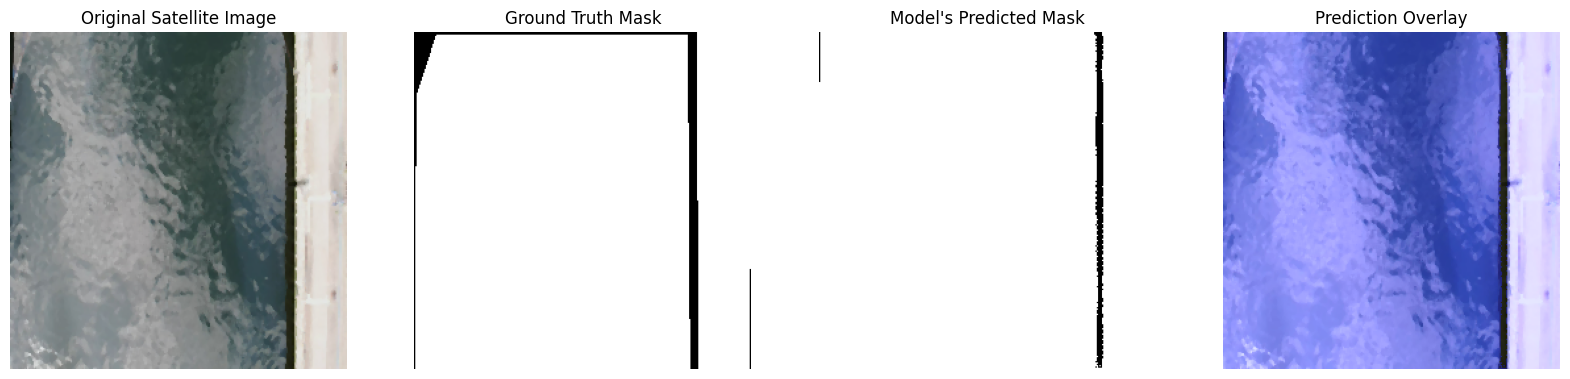

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


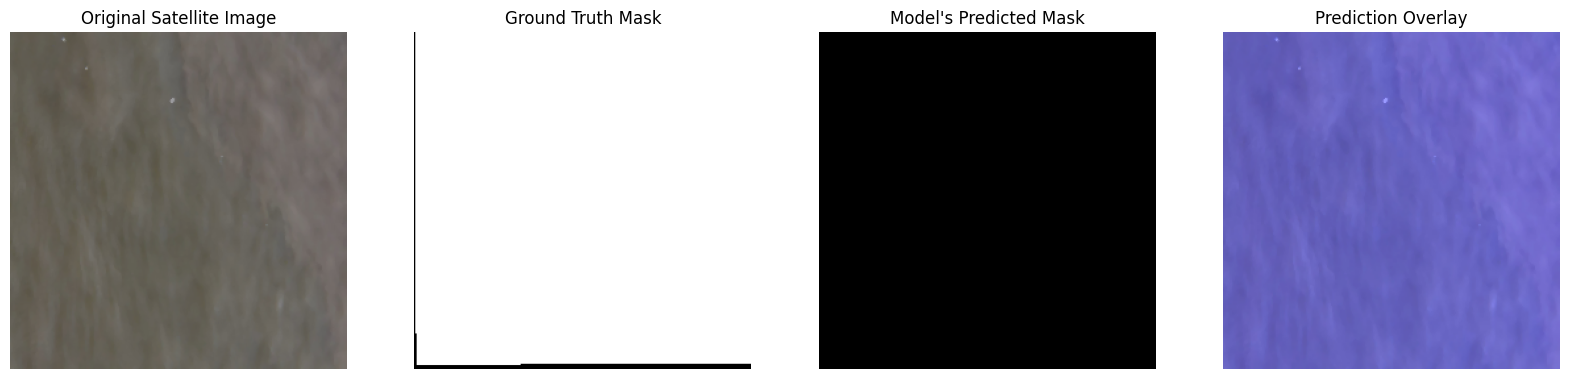

In [10]:
# ==============================================================================
#  Visualization of Results
# ==============================================================================
import numpy as np
import cv2

def display_predictions(model, dataset, num_predictions=3):

    print("\nDisplaying model predictions on sample images...")
    for image, mask in dataset.take(num_predictions):
        # The dataset is batched, so we take the first image from the batch
        # to visualize.
        sample_image = image[0]
        sample_mask = mask[0]

        # Use the trained model to predict the mask for the sample image.

        prediction = model.predict(np.expand_dims(sample_image, axis=0))

        # The model outputs probabilities. We apply a 0.5 threshold to get a binary mask.
        predicted_mask = (prediction[0] > 0.5).astype(np.uint8)


        # --- Create an overlayed image for better visualization ---

        predicted_mask_colored = cv2.cvtColor(predicted_mask * 255, cv2.COLOR_GRAY2BGR)
        predicted_mask_colored[np.where((predicted_mask_colored==[255,255,255]).all(axis=2))] = [0,0,255]

        # Convert the original image tensor back to a displayable format
        original_image_display = (sample_image.numpy() * 255).astype(np.uint8)

        # Blend the original image and the colored mask
        overlayed_image = cv2.addWeighted(original_image_display, 1, predicted_mask_colored, 0.4, 0)

        # --- Display the results ---
        plt.figure(figsize=(20, 5))

        plt.subplot(1, 4, 1)
        plt.title("Original Satellite Image")
        plt.imshow(sample_image)
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(tf.squeeze(sample_mask), cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.title("Model's Predicted Mask")
        plt.imshow(tf.squeeze(predicted_mask), cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.title("Prediction Overlay")
        plt.imshow(overlayed_image)
        plt.axis('off')

        plt.show()


display_predictions(model, train_dataset, num_predictions=3)


Preparing the test dataset...
Test dataset created with 254 images.

Evaluating model performance on the test dataset...
16/16 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.9582 - dice_coefficient: 0.9631 - iou_metric: 0.9290 - loss: 0.1796 - precision: 0.9608 - recall: 0.9970

--- Final Test Results ---
loss: 0.1592
compile_metrics: 0.9660

Displaying model predictions on test images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


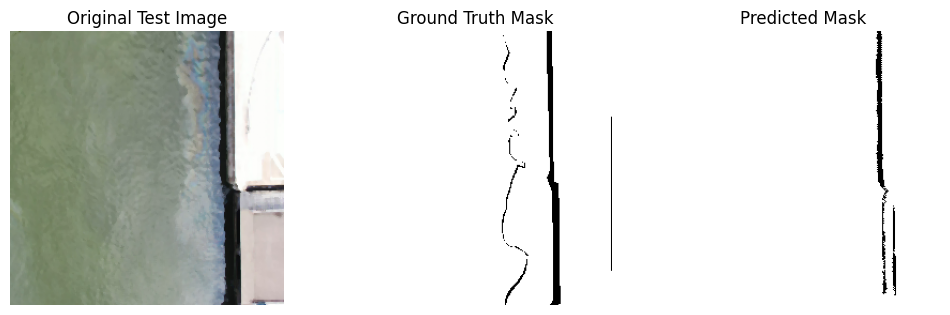

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


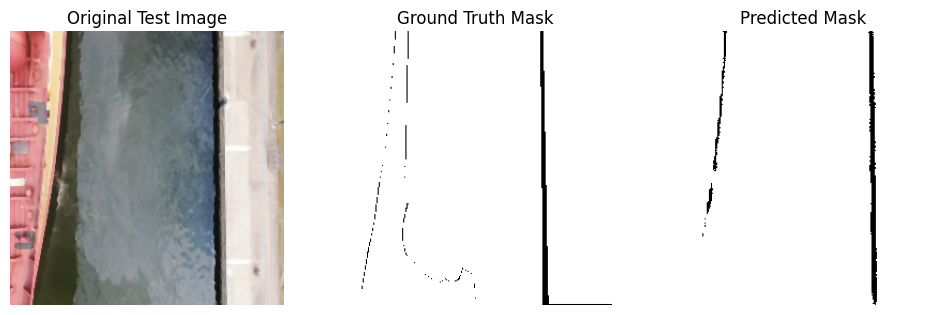

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


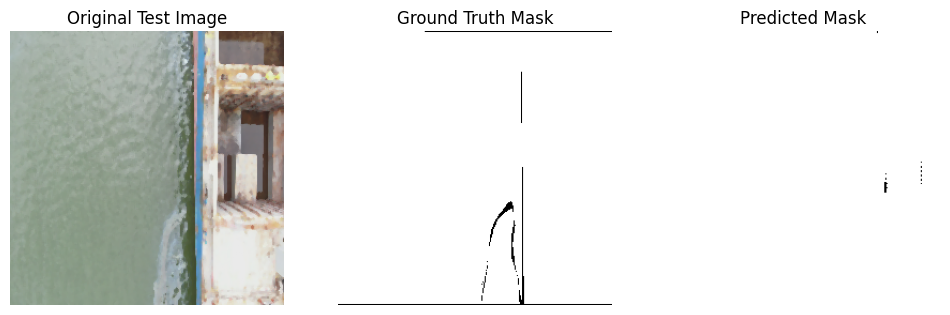

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


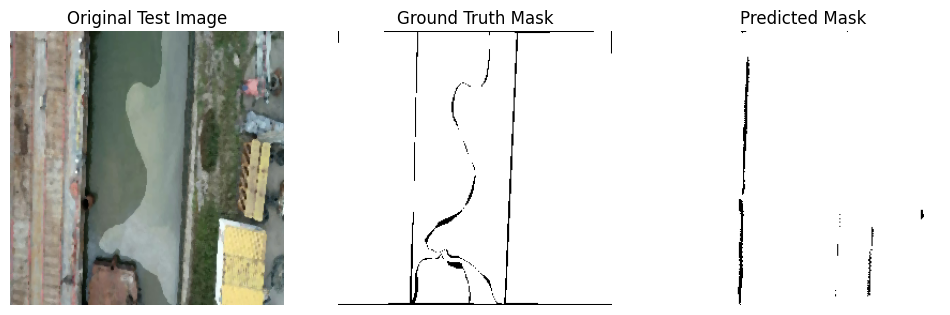

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


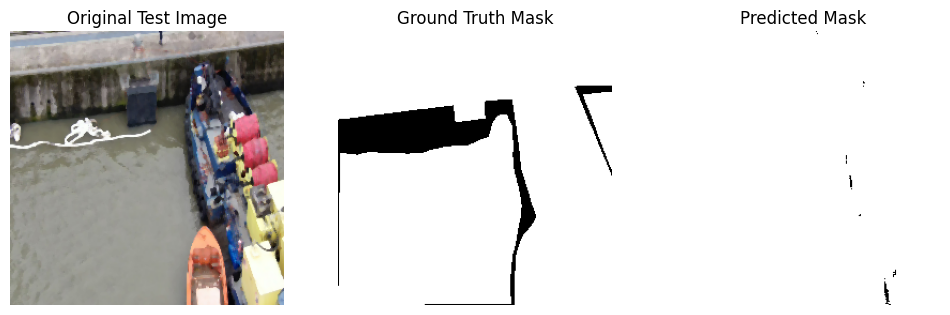


Final trained model saved as 'final_oil_spill_model.h5'


In [11]:
# ==============================================================================
# Final Evaluation and Testing on the Test Dataset
# ==============================================================================

# --- Step 1: Define Paths and Create the Test Dataset ---
print("\nPreparing the test dataset...")
TEST_IMG_DIR = '/content/drive/MyDrive/Oil_Spill_Dataset/dataset/test/images/'
TEST_MASK_DIR = '/content/drive/MyDrive/Oil_Spill_Dataset/dataset/test/masks/'

test_image_files = sorted([os.path.join(TEST_IMG_DIR, f) for f in os.listdir(TEST_IMG_DIR)])
test_mask_files = sorted([os.path.join(TEST_MASK_DIR, f) for f in os.listdir(TEST_MASK_DIR)])

# Create the TensorFlow Dataset for testing
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_files, test_mask_files))

# Map the correct function to the dataset
test_dataset = (
    test_dataset
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
print(f"Test dataset created with {len(test_image_files)} images.")

# --- Step 2: Quantitative Evaluation ---
# This calculates the final performance scores (Dice, IoU, etc.) on the entire test set.
print("\nEvaluating model performance on the test dataset...")
results = model.evaluate(test_dataset)

print("\n--- Final Test Results ---")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

# --- Step 3: Visual Testing ---
# This shows the model's predictions on a few sample images from the test set.
def display_test_predictions(model, dataset, num_predictions=5):
    print("\nDisplaying model predictions on test images...")
    for image, mask in dataset.take(num_predictions):
        # The dataset is batched, so we take the first image from the batch
        sample_image, sample_mask = image[0], mask[0]

        # Predict the mask
        prediction = model.predict(np.expand_dims(sample_image, axis=0))
        predicted_mask = (prediction[0] > 0.5).astype(np.uint8)

        # Display the results
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Original Test Image")
        plt.imshow(sample_image)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(tf.squeeze(sample_mask), cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(tf.squeeze(predicted_mask), cmap='gray')
        plt.axis('off')

        plt.show()

# Run the visualization on the test dataset
display_test_predictions(model, test_dataset)

# --- Step 4: Optional - Save the Final Model ---
model.save('final_oil_spill_model.h5')
print("\nFinal trained model saved as 'final_oil_spill_model.h5'")